# TP2 - MCMC

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres (disponible dans le premier notebook). Le deuxième exercice met en oeuvre une méthode de régression bayésienne linéaire.

### Instructions

1. Renommer votre notebook sous la forme `tp2b_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 10 Décembre 2023, 23h59.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss
from sklearn import datasets

### Partie 2 - Régression linéaire bayésienne parcimonieuse

On suppose le modèle de régression linéaire suivant :
$$ y_i \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)$$

On a :
* $y \in \mathbb{R}$, la variable que l'on cherche à prédire ;
* $\mathbf{x}_i \in \mathbb{R}^p$, les features ;
* $\boldsymbol{\beta} \in \mathbb{R}^p$, le vecteur de régression ;
* $\sigma^2$ la variance du bruit.

Nous adoptons une approche bayésienne. Les paramètres du modèle, $\boldsymbol{\beta}$ et $\sigma^2$, doivent donc être munis d'une loi a priori.

Dans cet exercice, nous allons suivre le modèle du *Bayesian LASSO* ([Park et al. (2008)](https://people.eecs.berkeley.edu/~jordan/courses/260-spring09/other-readings/park-casella.pdf)).

Le LASSO est une méthode de régression pénalisée classique (c'est la pénalisation en norme $\ell_1$ - vous connaissez la pénalisation en norme $\ell_2$ appelée *ridge regression*). Nous regardons ici sa version bayésienne. Les lois a priori sont les suivantes :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\beta_p | \sigma^2 & \sim \text{Laplace} \left( 0, \frac{\sqrt{\sigma^2}}{\lambda} \right)
\end{align}

$\lambda$ est le paramètre de régularisation. Il se trouve qu'en prenant une loi a priori de [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) pour les coefficients de régression, le problème du LASSO est le même que celui l'estimation MAP.

À partir des données $\mathcal{D} = \{ (\mathbf{x}_1, y_1), ... (\mathbf{x}_n, y_n) \}$, l'objectif est donc de caractériser la loi a posteriori $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$. Elle n'est pas tractable analytiquement. Nous allons donc échantillonner de cette loi à l'aide d'un algorithme MCMC, plus précisémment, un [échantillonneur de Gibbs](https://fr.wikipedia.org/wiki/%C3%89chantillonnage_de_Gibbs).

Il n'est pas possible de dériver un échantillonneur de Gibbs immédiatement. Il se trouve que le modèle peut être ré-écrit de la manière suivante :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\tau_i^2 & \sim \text{Exp} \left( \frac{\lambda^2}{2} \right) \\
\beta_j | \tau_j^2, \sigma^2 & \sim \mathcal{N}(0, \sigma^2 \tau_j^2) \\
y_i | \boldsymbol{\beta}, \sigma^2 & \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)
\end{align}

On peut alors trouver les lois conditionnelles :
\begin{align}
\boldsymbol{\beta} | \boldsymbol{\tau}, \sigma^2, \mathcal{D} \sim \mathcal{N}(\mathbf{A}^{-1} \mathbf{X}^{\top} \mathbf{y}, \sigma^2 \mathbf{A}),
\end{align}
avec $\mathbf{A} = (\mathbf{X}^{\top} \mathbf{X} + \mathbf{D}_{\tau})^{-1}$, où $\mathbf{D}_{\tau} = \text{diag}(\tau_1^{-2}, ..., \tau_p^{-2})$.
\begin{align}
\tau_j^{-2} | \boldsymbol{\beta}, \sigma^2, \mathcal{D} \sim \text{InvGaussian}\left( \sqrt{\frac{\lambda^2 \sigma^2}{\beta_j^2}}, \lambda^2 \right),
\end{align}
(Loi "Inverse-Gaussian" -> [ici](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution))
\begin{align}
\sigma^2 | \boldsymbol{\beta}, \boldsymbol{\tau}, \mathcal{D} \sim \text{IG}\left( a_0 + \frac{n+p}{2}, b_0 + \frac{1}{2} || \mathbf{y - X} \boldsymbol{\beta} ||^2_2 + \frac{1}{2} \sum_{j=1}^p \frac{\beta_j^2}{\tau_j^2} \right)
\end{align}

In [2]:
# Pre-processing the data

# Load the dataset
diabetes = datasets.load_diabetes()

# Print dataset description
print(diabetes.DESCR)

# Features
X = diabetes.data
X = X/np.std(X, axis = 0) # Standardize
N,P = X.shape

# Target
y = diabetes.target
y = (y-np.mean(y))/np.std(y) # Standardize

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

**Q1.** Écrire une fonction implémentant l'échantillonnage de Gibbs dans ce modèle, qui prend en arguments :
* Les données sous forme matricielle $\mathbf{X}$ et $\mathbf{y}$
* Le nombre d'échantillons $N_g$
* La taille du *burn-in* $N_b$
* Les hyper-paramètres du modèle : $a_0, b_0, \lambda$

Elle retourne $N_g$ échantillons du posterior $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$.

**Attention !** Bien lire la doc. de `scipy.stats.invgauss` pour savoir quels paramètres utiliser.

In [110]:
np.linalg.norm([[1,1],[0,0]])

1.4142135623730951

In [3]:
def bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l):
    """
    Bayesian Lasso with Gibbs sampling
    """
    N,P = X.shape
    # Initialize
    beta = np.zeros((Ng+1,P))
    sigma2 = np.ones(Ng)
    tau = np.zeros((Ng+1,P))
  
    
    #tau2[0] = np.ones(P)
    
    
    for i in range(0,Ng):
        # Sample beta
        A =  np.linalg.inv(np.dot(X.T,X)+ np.diag(tau[i]))
        B = np.dot(X.T,y)
        beta[i+1] = np.random.multivariate_normal(np.dot(A,B), sigma2[i]*A)
   
        # Sample tau2
        
        for j in range(P):
            tau[i+1,j] = np.sqrt(1/ss.invgauss.rvs(np.sqrt((l**2)*sigma2[i]/(beta[i+1][j]**2)), scale = 1/l**2))
        # Sample sigma2
        summation = np.sum([(beta[i+1][j]**2)/(tau[i+1][j]**2) for j in range(P)])/2
        sigma2[i] = ss.invgamma.rvs(a0+((N+P)/2), scale = b0+summation+(np.linalg.norm(y-np.dot(X,beta[i+1]))**2)/2)
        
    return sigma2[Nb:], beta[Nb:], tau[Nb:]
        

**Q2.** Faire tourner la chaîne MCMC avec les paramètres suivants : $N_g = N_b = 1000$, $a_0 = b_0 = 1$, $\lambda = 10$.

* Afficher le *traceplot* pour un paramètre de votre choix. Commenter.
* Pour chacun des paramètres $\boldsymbol{\beta}$ et $\sigma^2$, afficher un histogramme ou un KDE des $N_g$ échantillons obtenus. Afficher sur le même plot la valeur de l'estimation MMSE et MAP. Enfin, donner l'intervalle de crédibilité à 95%. (Cf. dernier chapitre du cours Intro à l'Estimation)

In [4]:
Ng = 5000
Nb = 400
a0 = 1
b0 = 1
l = 10
sigma2, beta, tau = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l)

In [5]:
g = ss.invgauss(1, scale = 1/1.2)
g.pdf(0.5)

0.901485001187469

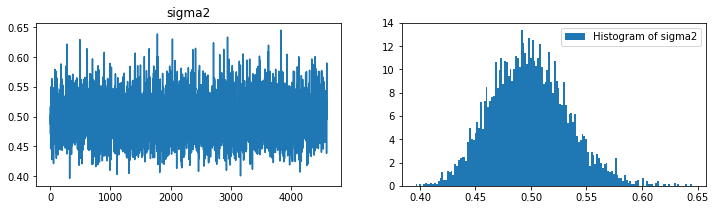

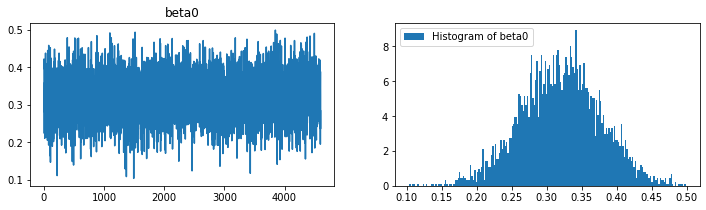

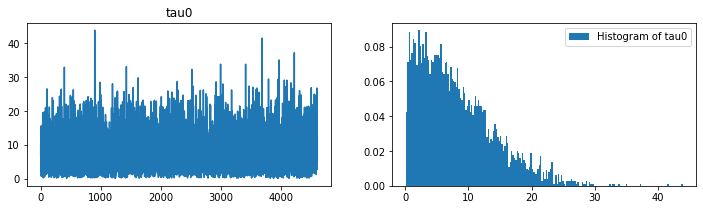

In [6]:
# Plot the sigma2 
plt.figure(figsize=(12,3))
ax = plt.subplot(121)
ax.plot(sigma2, label = 'sigma2')
ax.set_title('sigma2')
ax = plt.subplot(122)
_ = ax.hist(sigma2, bins = 150, density = True,label='Histogram of sigma2')
plt.legend()
plt.show()
# Plot the beta
plt.figure(figsize=(12,3))
ax = plt.subplot(121)
i = 2
ax.plot(beta[:,i], label = 'beta0')
ax.set_title('beta0')
ax = plt.subplot(122)
_ = ax.hist(beta[:,i], bins = 200, density = True,label='Histogram of beta0')
plt.legend()
plt.show()

# Plot the tau2
plt.figure(figsize=(12,3))
ax = plt.subplot(121)
i = 3
ax.plot(tau[:,i], label = 'tau0')
ax.set_title('tau0')
ax = plt.subplot(122)
_ = ax.hist(tau[:,i], bins =200, density = True,label='Histogram of tau0')
plt.legend()
plt.show()



**Q3.** Générer 1000 échantillons de la loi prédictive a posteriori pour le nouveau point $x_{\text{new}}$ (défini dans le code) et tracer un histogramme ou un KDE. Commenter.

In [8]:
x_new = np.array([ 1.41145807,  1.06548848,  0.30006161,  0.45984057, -0.52475728,
       -1.70643289,  1.02259953,  1.49710409, -1.25030999,  0.84817082])
 

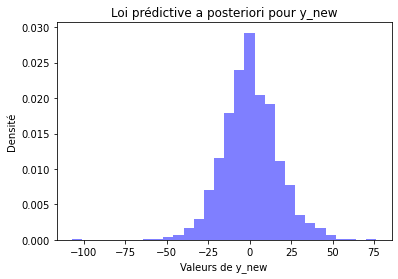

In [9]:
sigma2_samples, beta_samples, tau_samples = bayesian_lasso_gibbs(X, y, Ng=1000, Nb=100, a0=1, b0=1, l=1)

y_new_samples = []

for i in range(len(sigma2_samples)):
    # Échantillon de tau pour chaque dimension
    tau_new = np.sqrt(1 / np.random.wald(np.sqrt((l**2) * sigma2_samples[i] / (beta_samples[i]**2)), 1 / l**2))
    
    # Échantillon de beta pour chaque dimension
    beta_new = np.random.normal(0, tau_new * sigma2_samples[i], len(x_new))
    
    # Prédiction pour y_new
    y_new = np.dot(x_new, beta_new)
    y_new_samples.append(y_new)

# Afficher un histogramme des échantillons de y_new
plt.hist(y_new_samples, bins=30, density=True, alpha=0.5, color='blue')
plt.title('Loi prédictive a posteriori pour y_new')
plt.xlabel('Valeurs de y_new')
plt.ylabel('Densité')
plt.show()

**Q4.** Étudier l'influence du paramètre lambda sur l'inférence des paramètres.

Sans l'implémenter, à l'aide de vos connaissances, pouvez-vous proposer une méthode permettant de choisir lambda ?

In [10]:
X.shape

(442, 10)

In [20]:
# Définir une plage de valeurs pour lambda
lambda_values = [0.1, 0.5, 1.0, 2.0, 5.0]


beta_samples_list = []
sigma2_samples_list = []

for l in lambda_values:
    # Échantillonner avec la valeur actuelle de lambda
    sigma2_samples, beta_samples, _ = bayesian_lasso_gibbs(X, y, Ng=1000, Nb=100, a0=1, b0=1, l=l)
    
    # Stocker les résultats
    beta_samples_list.append(beta_samples)
    sigma2_samples_list.append(sigma2_samples)

In [24]:
len(beta_samples_list[0])

901

# Analyse de l'évolution des coefficients en fonction de lambda : 

([<matplotlib.axis.XTick at 0x1955cc59fc0>,
 [Text(1, 0, 'Lambda = 0.1'),
  Text(2, 0, 'Lambda = 0.5'),
  Text(3, 0, 'Lambda = 1.0'),
  Text(4, 0, 'Lambda = 2.0'),
  Text(5, 0, 'Lambda = 5.0')])

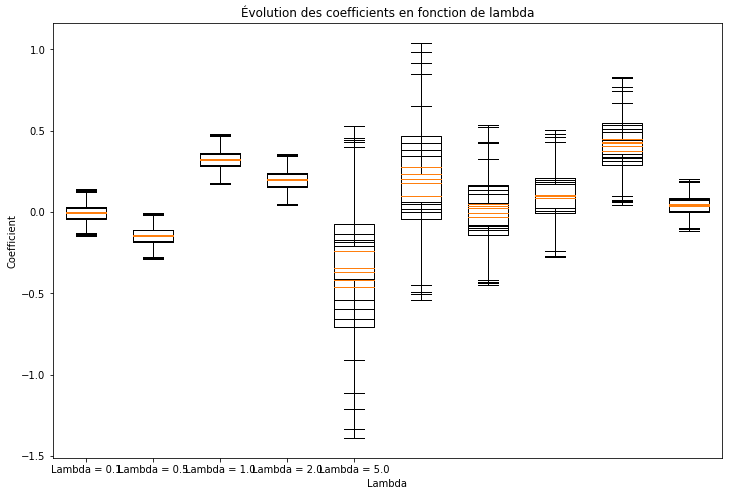

In [19]:
plt.figure(figsize=(12, 8))

coefficients_evolution = []

for i, l in enumerate(lambda_values):
    coefficients_lambda = np.array(beta_samples_list[i])  # Convertir en tableau numpy
    coefficients_evolution.append(coefficients_lambda)
    
    # Plot des boîtes à moustaches (boxplots) pour chaque coefficient
    plt.boxplot(coefficients_lambda, positions=[i+1 for i in range(len(coefficients_lambda[0]))], widths=0.6, showfliers=False)

plt.title("Évolution des coefficients en fonction de lambda")
plt.xlabel("Lambda")
plt.ylabel("Coefficient")
plt.xticks(range(1, len(lambda_values) + 1), [f'Lambda = {l}' for l in lambda_values])



# Analyse de l'évolution de la variance du bruit en fonction de lambda :

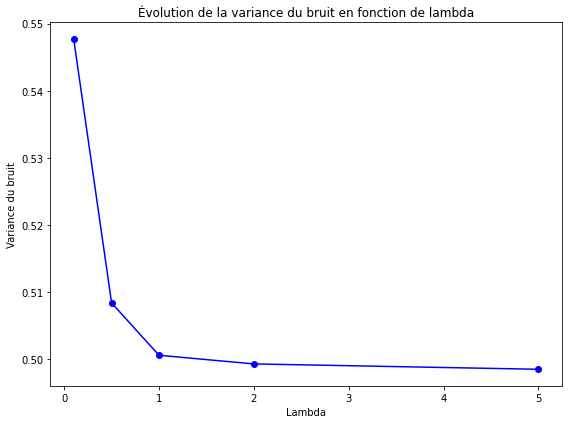

In [18]:
plt.figure(figsize=(8,6))

# Calculer la moyenne de la variance du bruit pour chaque valeur de lambda
variance_evolution = [np.mean(sigma2_samples) for sigma2_samples in sigma2_samples_list]

# Plot de la variance du bruit en fonction de lambda
plt.plot(lambda_values, variance_evolution, marker='o', linestyle='-', color='b')
plt.title("Évolution de la variance du bruit en fonction de lambda")
plt.xlabel("Lambda")
plt.ylabel("Variance du bruit")

plt.tight_layout()
plt.show()

**Questions bonus**. Le TP est déjà long. Votre objectif premier est d'effectuer les questions précédentes correctement.

S'il vous reste du temps et de la motivation, voici deux questions "papier-crayon" :
* Montrer que l'estimation MAP dans un modèle avec un *prior* Laplace pour les coefficients de régression mène bien au même problème que le LASSO
* Dériver la loi conditionnelle pour $\boldsymbol{\beta}$ ou $\sigma^2$. Attention ! Le calcul de la loi conditionnelle de $\tau_i$ est quant à lui très compliqué. Ne le tentez pas sans l'aide d'un(e) professionnel(le).